In [51]:
import scipy         
import datetime
from scipy.linalg import expm,det
import scipy.sparse as sparse
from quspin.operators import hamiltonian, commutator, exp_op # Hamiltonians and operators
from quspin.basis import tensor_basis, spin_basis_1d # bases
import numpy as np # general math functions
import matplotlib.pyplot as plt # plotting library
from numba import jit
from scipy.integrate import solve_ivp,odeint
from functools import reduce
import datetime


In [52]:
L = 7 #system size
l=1 #spin length
M = -0.35
m_epsilon = 0
N=3
no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)

In [53]:
#construct basis
basis=spin_basis_1d(L=L,S = str(l))
print(basis)

reference states: 
array index   /   Fock state   /   integer repr. 
        0.         |2 2 2 2 2 2 2>           2186  
        1.         |2 2 2 2 2 2 1>           2185  
        2.         |2 2 2 2 2 2 0>           2184  
        3.         |2 2 2 2 2 1 2>           2183  
        4.         |2 2 2 2 2 1 1>           2182  
        5.         |2 2 2 2 2 1 0>           2181  
        6.         |2 2 2 2 2 0 2>           2180  
        7.         |2 2 2 2 2 0 1>           2179  
        8.         |2 2 2 2 2 0 0>           2178  
        9.         |2 2 2 2 1 2 2>           2177  
       10.         |2 2 2 2 1 2 1>           2176  
       11.         |2 2 2 2 1 2 0>           2175  
       12.         |2 2 2 2 1 1 2>           2174  
       13.         |2 2 2 2 1 1 1>           2173  
       14.         |2 2 2 2 1 1 0>           2172  
       15.         |2 2 2 2 1 0 2>           2171  
       16.         |2 2 2 2 1 0 1>           2170  
       17.         |2 2 2 2 1 0 0>           21

In [54]:
#initialisation of the Gauss laws

liste = []
liste_m = []
gauss_law_map = []
Gauss_law = []
gauss_law_matrix = []
z_comp_minf = [[-m_epsilon,0]]
z_comp_pinf = [[m_epsilon,L-1]]

for i in range(L+1):
    liste.append([[1.,i]])
    liste_m.append([[-1.,i]])
    if i == 0:
        gauss_law_map.append([
            ["z",liste[0]],
            ["I",z_comp_minf],

        ])
    
    elif (i == L) & (i%2 == 0):
        gauss_law_map.append([
            ["z",liste_m[i-1]],
            ["I",z_comp_pinf],
        ])
    
    elif (i == L) & (i%2 == 1):
        gauss_law_map.append([
            ["z",liste_m[i-1]],
            ["I",liste[i-1]],
            ["I",z_comp_pinf],

        ])        
        
    elif i%2 == 0:
        gauss_law_map.append([
            ["z",liste[i]],
            ["z",liste_m[i-1]],
        ])
    elif i%2 == 1:
        gauss_law_map.append([
            ["z",liste[i]],
            ["z",liste_m[i-1]],  
            ["I",liste[i]]
        ])
    Gauss_law.append(hamiltonian(gauss_law_map[i],dynamic_list=[],basis=basis,**no_checks))
for i in range(L+1):
    gauss_law_matrix.append(Gauss_law[i].tocsc())

In [55]:
B = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        B[i][j] = (-2*l+i)**j
b = np.zeros(int(4*l)+1)
b[int(2*l)+1] = 1.
solution = scipy.linalg.solve(B,b)
y = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    y[i] = solution[i]
print(y)
print(b)

[ 0.          0.66666667  0.66666667 -0.16666667 -0.16666667  0.
  0.        ]
[0. 0. 0. 1. 0.]


In [56]:
C = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        C[i][j] = (-2*l+i+1)**j
c = np.zeros(int(4*l)+1)
c[int(2*l)] = 1.
solution = scipy.linalg.solve(C,c)
z = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    z[i] = solution[i]
print(z)
print(c)

[ 0.    1.5   0.25 -1.    0.25  0.    0.  ]
[0. 0. 1. 0. 0.]


In [57]:
#projectors on g=1 for every site
Proj = [sparse.csr_matrix((basis.Ns,basis.Ns)) for i in range(L+1)]
for i in range(int(L/2)+1):
    for j in range(int(4*l)+1):
        Proj[2*i] += y[j]*gauss_law_matrix[2*i]**j
for i in range(int(L/2)+1):
    for j in range(int(4*l)+1):
        Proj[2*i+1] += z[j]*gauss_law_matrix[2*i+1]**j

In [58]:
A = np.zeros((int(2*l)+1,int(2*l)+1), dtype = complex)
for i in range(int(2*l)+1):
    for j in range(int(2*l)+1):
        A[i][j] = (-l+i)**j
b = np.zeros(int(2*l)+1,dtype = complex)
for i in range(int(2*l)+1):
    b[i] = (-1)**(-l+i)
solution = scipy.linalg.solve(A,b)
x = np.zeros(int(2*3/2)+1, dtype = complex)
for i in range(int(2*l)+1):
    x[i] = solution[i]
print(x)
print(x.conj())

[ 1.+0.j  0.+0.j -2.-0.j  0.+0.j]
[ 1.-0.j  0.-0.j -2.+0.j  0.-0.j]


In [59]:
D = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        D[i][j] = (-2*l+i)**j
d = np.zeros(int(4*l)+1)
d[int(2*l)] = 1.
solution = scipy.linalg.solve(D,d)
dd = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    dd[i] = solution[i]
print(dd)
print(d)

[ 1.    0.   -1.25 -0.    0.25  0.    0.  ]
[0. 0. 1. 0. 0.]


In [60]:
E = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        E[i][j] = (-2*l+i+1)**j
e = np.zeros(int(4*l)+1)
e[int(2*l)-1] = 1.
solution = scipy.linalg.solve(E,e)
ee = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    ee[i] = solution[i]
print(ee)
print(e)

[ 1.         -0.83333333 -0.83333333  0.83333333 -0.16666667  0.
  0.        ]
[0. 1. 0. 0. 0.]


In [61]:
#projectors on g=0 for every site
Proj_0 = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(L+1)]
for i in range(int(L/2)+1):
    for j in range(int(4*l)+1):
        Proj_0[2*i] += dd[j]*gauss_law_matrix[2*i]**j
for i in range(int(L/2)+1):
    for j in range(int(4*l)+1):
        Proj_0[2*i+1] += ee[j]*gauss_law_matrix[2*i+1]**j

In [62]:
const_term = []
linear_term = []
quadratic_term = []
cubic_term = []

const_term_conj = []
linear_term_conj = []
quadratic_term_conj = []
cubic_term_conj = []

interaction_p = []
interaction_m = []

for i in range(L-1):
    const_term.append([[x[0]/(2*np.sqrt(l*(l+1))),i]])
    linear_term.append([[x[1]/(2*np.sqrt(l*(l+1))),i,i+1]])
    quadratic_term.append([[x[2]/(2*np.sqrt(l*(l+1))),i,i+1,i+1]])
    cubic_term.append([[(x[3])/(2*np.sqrt(l*(l+1))),i,i+1,i+1,i+1]])

    const_term_conj.append([[x.conj()[0]/(2*np.sqrt(l*(l+1))),i]])
    linear_term_conj.append([[x.conj()[1]/(2*np.sqrt(l*(l+1))),i,i+1]])
    quadratic_term_conj.append([[x.conj()[2]/(2*np.sqrt(l*(l+1))),i,i+1,i+1]])
    cubic_term_conj.append([[x.conj()[3]/(2*np.sqrt(l*(l+1))),i,i+1,i+1,i+1]])


    interaction_p.append([
        ["+", const_term[i]],
        ["+z", linear_term[i]],
        ["+zz", quadratic_term[i]],
        ["+zzz", cubic_term[i]],


    ])

    interaction_m.append([
        ["-", const_term_conj[i]],
        ["-z", linear_term_conj[i]],
        ["-zz", quadratic_term_conj[i]],
        ["-zzz", cubic_term_conj[i]],


    ])
    
const_term.append([[(0.5*(-1)**m_epsilon)/np.sqrt(l*(l+1)),L-1]])
const_term_conj.append([[(0.5*np.conj((-1)**m_epsilon))/np.sqrt(l*(l+1)),L-1]])

interaction_p.append([
    ["+", const_term[L-1]]
])
interaction_m.append([
    ["-", const_term_conj[L-1]]
])

kin_energy = [[0.5,i,i] for i in range(L)]
mass_term = [[2*(-1)**i*M,i] for i in range(L)]

kin_mass_map = [
            ["zz", kin_energy], 
            ["z", mass_term], 
]

H_int_p = []
H_int_m = []
interaction = [sparse.csr_matrix((basis.Ns,basis.Ns),dtype = complex) for i in range(L)]
h_int = sparse.csr_matrix((basis.Ns,basis.Ns))
for i in range(L):
    H_int_p.append(hamiltonian(interaction_p[i],dynamic_list=[],basis=basis,**no_checks))
    H_int_m.append(hamiltonian(interaction_m[i],dynamic_list=[],basis=basis,**no_checks))
    interaction[i] = (Proj[i]@H_int_p[i].tocsc()@Proj[i+1]+Proj[i+1]@H_int_m[i].tocsc()@Proj[i])

H_kin_mass = hamiltonian(kin_mass_map,dynamic_list=[],basis=basis,**no_checks)
h_kin_mass = H_kin_mass.tocsc()

h_int = 0

for i in range(L):
    h_int += interaction[i]


full_ham_matrix = h_kin_mass + h_int #Spin-1 Hamiltonian without the local contstaints

for i in range(L+1):
    full_ham_matrix = (Proj[i]+Proj_0[i])@full_ham_matrix@(Proj[i]+Proj_0[i])
full_ham_matrix = 1.*full_ham_matrix

G=0
for i in range(L+1):
    G += 10*(Gauss_law[i]**2-Gauss_law[i])**2
constraint_full_matrix = G.tocsc()
constrained_full_ham_matrix= 1*(full_ham_matrix + constraint_full_matrix) #Spin-1 Hamiltonian with the local contstaints as a penalty term


In [63]:
#eigenvalues and eigenvectors of the Spin-1 Hamiltonian without the local contstaints
eigenval, eigenvec = scipy.sparse.linalg.eigsh(constrained_full_ham_matrix,k = 3,which = "SA")
print(eigenval[eigenval<=1e1])


[-2.70349906 -2.26253799 -1.99873048]


In [64]:
#s_xy = [[1.,i,i+1] for i in range(L-1)]
#s_z = [[0.47,i] for i in range(L)]

#ham_map = [
    
#    ["xx",s_xy],
#    ["yy",s_xy],
#    ["z",s_z],


#]

#XYZ = hamiltonian(ham_map,dynamic_list=[],basis=basis,**no_checks)


In [87]:
def rot_sigma(k,i,j,phi,theta):
    if k>=L:
        print("Warning! Rotations apply to k<=L-1!")
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    rot_matrix = expm(-1j*theta*sigma)
    if k==0:
        tensprod = rot_matrix
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,rot_matrix)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod


def rot_sigma_e(i,j,phi,theta):
    sigma_e = sparse.identity(basis.Ns,dtype = complex)
    for k in range(1,int(L/2)):
        sigma_e = rot_sigma(2*k,i,j,phi,theta)@sigma_e
    return(sigma_e)

def rot_sigma_o(i,j,phi,theta):
    sigma_o = sparse.identity(basis.Ns,dtype = complex)
    for k in range(int(L/2)):
        sigma_o = rot_sigma(2*k+1,i,j,phi,theta)@sigma_o
    return(sigma_o)

def rot_sigma_r(i,j,phi,theta):
    sigma_r = sparse.identity(basis.Ns,dtype = complex)
    sigma_r = rot_sigma(0,i,j,phi,theta)@rot_sigma(L-1,i,j,phi,theta)
    return(sigma_r)


def sigma(k,i,j,phi):
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    if k==0:
        tensprod = sigma
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,sigma)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod


def sigma_e(i,j,phi):
    sigma_e = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    sigma_e = sparse.csc_matrix(sigma_e)
    for k in range(1,int(L/2)):
        sigma_e +=sigma(2*k,i,j,phi)
    return sigma_e

def sigma_o(i,j,phi):
    sigma_o = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    sigma_o = sparse.csc_matrix(sigma_o)
    for k in range(int(L/2)):
        sigma_o +=sigma(2*k+1,i,j,phi)
    return sigma_o

def sigma_r(i,j,phi):
    sigma_r = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    sigma_r = sparse.csc_matrix(sigma_r)
    sigma_r = sigma(0,i,j,phi)+sigma(L-1,i,j,phi)
    return sigma_r

In [92]:

def ms_hamiltonian(i,j,phi):
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    summe = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for k in range(L):
        if k == 0:
            tensprod = sigma
            for m in range(L-1):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = tensprod.toarray()
        else:
            tensprod = sparse.identity(2*l+1)
            for i in range(1,k):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = scipy.sparse.kron(tensprod,sigma)
            for i in range(k+1,L):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = tensprod.toarray()
        summe +=tensprod
    return summe@summe
                
matrix_part = ms_hamiltonian(1,2,0)
ms_ham_eigenval, ms_ham_eigenvec = scipy.linalg.eigh(matrix_part)




def ms_gate_global(theta):
    return ms_ham_eigenvec@np.diag(np.exp(-1j*ms_ham_eigenval*theta))@ms_ham_eigenvec.T.conj()

    
def ms_hamiltonian_1(i,j,phi):
    sigma_p = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma_m = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma_z = np.zeros((2*l+1,2*l+1),dtype = complex)
    
    sigma_p[2*l-j][2*l-i] = 1.
    sigma_m[2*l-i][2*l-j] = 1.
    
    sigma_z[2*l-i][2*l-i] = 1.
    sigma_z[2*l-j][2*l-j] = -1.
    
    sigma_p = sparse.csc_matrix(sigma_p)
    sigma_m = sparse.csc_matrix(sigma_m)
    sigma_z = sparse.csc_matrix(sigma_z)

    sigma_big_p = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for n in range(L)]
    sigma_big_m = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for n in range(L)]
    sigma_big_z = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for n in range(L)]

    summe = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    
    for k in range(L):
        if k == 0:
            tensprod_p = sigma_p
            tensprod_m = sigma_m
            tensprod_z = sigma_z

            for m in range(L-1):
                tensprod_p = scipy.sparse.kron(tensprod_p,sparse.identity(2*l+1))
                tensprod_m = scipy.sparse.kron(tensprod_m,sparse.identity(2*l+1))
                tensprod_z = scipy.sparse.kron(tensprod_z,sparse.identity(2*l+1))
            tensprod_p = tensprod_p.toarray()
            tensprod_m = tensprod_m.toarray()
            tensprod_z = tensprod_z.toarray()
        else:
            tensprod_p = sparse.identity(2*l+1)
            tensprod_m = sparse.identity(2*l+1)
            tensprod_z = sparse.identity(2*l+1)
            
            for i in range(1,k):
                tensprod_p = scipy.sparse.kron(tensprod_p,sparse.identity(2*l+1))
                tensprod_m = scipy.sparse.kron(tensprod_m,sparse.identity(2*l+1))
                tensprod_z = scipy.sparse.kron(tensprod_z,sparse.identity(2*l+1))
            tensprod_p = scipy.sparse.kron(tensprod_p,sigma_p)
            tensprod_m = scipy.sparse.kron(tensprod_m,sigma_m)
            tensprod_z = scipy.sparse.kron(tensprod_z,sigma_z)            
            for i in range(k+1,L):
                tensprod_p = scipy.sparse.kron(tensprod_p,sparse.identity(2*l+1))
                tensprod_m = scipy.sparse.kron(tensprod_m,sparse.identity(2*l+1))
                tensprod_z = scipy.sparse.kron(tensprod_z,sparse.identity(2*l+1))
            tensprod_p = tensprod_p.toarray()
            tensprod_m = tensprod_m.toarray()    
            tensprod_z = tensprod_z.toarray() 
            
        sigma_big_p[k] = tensprod_p
        sigma_big_m[k] = tensprod_m
        sigma_big_z[k] = tensprod_z

    for k in range(L):
        summe += 1.*sigma_big_z[k]
        for kk in range(k+1,L):
            summe += 1./np.abs(k-kk)**2*(sigma_big_p[k]@sigma_big_m[kk] + sigma_big_m[k]@sigma_big_p[kk])
    return summe
                
matrix_part_1 = ms_hamiltonian_1(1,2,0)
ms_ham_eigenval_1, ms_ham_eigenvec_1 = scipy.linalg.eigh(matrix_part_1)




def ms_gate_global_1(theta):
    return ms_ham_eigenvec_1@np.diag(np.exp(-1j*ms_ham_eigenval_1*theta))@ms_ham_eigenvec_1.T.conj()

In [159]:
%time sigma_e(0,1,0)@rot_sigma_e(0,0,1,np.pi/7)

CPU times: user 32.3 ms, sys: 15.8 ms, total: 48.1 ms
Wall time: 46.5 ms


<2187x2187 sparse matrix of type '<class 'numpy.complex128'>'
	with 2916 stored elements in Compressed Sparse Column format>

In [160]:
#initial state
string = ""
for i in range(L):
    string +="1"
psi_0 = np.zeros(basis.Ns)
i_0 = basis.index(string)
psi_0[i_0] = 1.

In [161]:
def R(i,theta):
    
    if i%11 == 0:
        return(ms_gate_global(theta))

    if i%11 == 1:
        return(ms_gate_global_1(theta))

    if i%11 == 2:
        return(rot_sigma_e(0,1,0,theta).toarray())


    if i%11 == 3:
        return(rot_sigma_e(0,2,0,theta).toarray())

    
    if i%11 == 4:
        return(rot_sigma_e(1,2,np.pi/2,theta).toarray())
    
    
    if i%11 == 5:
        return(rot_sigma_o(0,1,0,theta).toarray())


    if i%11 == 6:
        return(rot_sigma_o(0,2,0,theta).toarray())

    
    if i%11 == 7:
        return(rot_sigma_o(1,2,np.pi/2,theta).toarray())

    if i%11 == 8:
        return(rot_sigma_r(0,1,0,theta).toarray())


    if i%11 == 9:
        return(rot_sigma_r(0,2,0,theta).toarray())

    
    if i%11 == 10:
        return(rot_sigma_r(1,2,np.pi/2,theta).toarray())
    
def S(i):
    
    if i%11 == 0:
        return(-1j*matrix_part)
    
    if i%11 == 1:
        return(-1j*matrix_part_1)

    if i%11 == 2:
        return(-1j*sigma_e(0,1,0).toarray())

    
    if i%11 == 3:
        return(-1j*sigma_e(0,2,0).toarray())

    
    if i%11 == 4:
        return(-1j*sigma_e(1,2,np.pi/2).toarray())


     
    if i%11 == 5:
        return(-1j*sigma_o(0,1,0).toarray())

    
    if i%11 == 6:
        return(-1j*sigma_o(0,2,0).toarray())

    
    if i%11 == 7:
        return(-1j*sigma_o(1,2,np.pi/2).toarray())

     
    if i%11 == 8:
        return(-1j*sigma_r(0,1,0).toarray())

    
    if i%11 == 9:
        return(-1j*sigma_r(0,2,0).toarray())

    
    if i%11 == 10:
        return(-1j*sigma_r(1,2,np.pi/2).toarray())


In [162]:
coeff = 11

In [179]:
matr = full_ham_matrix.toarray()
ones = np.ones(coeff*N)
ID = np.identity(coeff*N)
psi_0_conj = np.conj(psi_0)
A = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for i in range(coeff*N)]
B = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for i in range(coeff*N)]
DD = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for i in range(coeff*N)]

dd = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for i in range(coeff*N)]

In [205]:
def rhs(t,theta):
    #A = [-1j*entanglement_ham.toarray()@exp_ent(theta[0]),-1j*sigma_z.toarray()@exp_sigma_z(theta[1]),-1j*sigma_x.toarray()@exp_sigma_x(theta[2]),-1j*sigma_z.toarray()@exp_sigma_z(theta[3])]
    #B = [exp_ent(theta[0]),exp_sigma_z(theta[1]),exp_sigma_x(theta[2]),exp_sigma_z(theta[3])]
    ID = np.identity(coeff*N)

    print(datetime.datetime.now())
    for k in range(coeff*N):
        A[k] = S(k)@R(k,theta[k])
        print("A",k,datetime.datetime.now())
        B[k] = R(k,theta[k])
        print("B",k,datetime.datetime.now())

    print(datetime.datetime.now())
    for i in range(coeff*N):
        buffer = B
        print("buffer",i,datetime.datetime.now())
        buffer[i] = A[i]
        print("buffer[i]",i,datetime.datetime.now())

        DD[i] = reduce(np.dot,buffer)
        print("DD[i]",i,datetime.datetime.now())
        DD = np.array(DD)


    print(datetime.datetime.now())

    X = np.zeros((coeff*N,coeff*N),dtype = complex)
    Y = np.zeros(coeff*N,dtype = complex)

    BBB = reduce(np.dot,B)
    DD_d = np.einsum("kij->kji",DD.conj())
    BBB_dagger = BBB.conj().T

    print(datetime.datetime.now())
      

    psi_conj_d = np.einsum("m,imn->in",psi_0_conj,DD_d)
    psi_d = np.einsum("jnl,l->jn",DD,psi_0)
    
    psi_conj_b = np.einsum("m,mn->n",psi_0_conj,BBB_dagger)
    psi_b = np.einsum("lk,k->l",BBB,psi_0)

    X = np.einsum("in,jn->ij",psi_conj_d,psi_d)

    Y = np.einsum("il,ln,n->i",psi_conj_d,matr,psi_b)
    
    XX = np.einsum("il,l->i",psi_conj_d,psi_b)
    
    YY_1 = np.einsum("n,in->i",psi_conj_b,psi_d)
        
    YY_2 = np.einsum("i,ij,j",psi_conj_b,matr,psi_b)
    YY = YY_1*YY_2
    XX = np.outer(XX,XX)
    X_r = 2*np.real(X+XX)
    Y_i = 2*np.real(Y+YY)
    result = -np.linalg.pinv(X_r,rcond = 1e-6)@Y_i
    print(datetime.datetime.now())

    print(t)

    return result

In [206]:
stepp = 2000
t_final = 15

In [207]:
time_domain = np.linspace(0, t_final, stepp)
Y = []

In [208]:
# RK-4 method
def rk4(x0,y0,xn,n):
    global Y

    # Calculating step size
    h = (xn-x0)/n

    #print('\n--------SOLUTION--------')
    #print('-------------------------')    
    #print('x0\ty0\tyn')
    #print('-------------------------')
    for i in range(n):
        k1 = h * (rhs(x0, y0))
        k2 = h * (rhs((x0+h/2), (y0+k1/2)))
        k3 = h * (rhs((x0+h/2), (y0+k2/2)))
        k4 = h * (rhs((x0+h), (y0+k3)))
        k = (k1+2*k2+2*k3+k4)/6
        yn = y0 + k
        #print('%.4f\t%.4f\t%.4f'% (x0,y0,yn) )
        #print('-------------------------')
        y0 = yn
        x0 = x0+h
        Y.append(y0)
    
    #print('\nAt x=%.4f, y=%.4f' %(xn,yn))

# Inputs
#print('Enter initial conditions:')
#x0 = float(input('x0 = '))
#y0 = float(input('y0 = '))

#print('Enter calculation point: ')
#xn = float(input('xn = '))

#print('Enter number of steps:')
#step = int(input('Number of steps = '))

# RK4 method call


In [204]:
start_point = 0.001*np.ones(coeff*N)
#for i in range(4*N):
#    start_point[i] += i/4*N
rk4(0,0.001*np.ones(coeff*N),t_final,stepp)


2022-07-26 15:22:42.380322
A 0 2022-07-26 15:22:43.567845
B 0 2022-07-26 15:22:44.353679
A 1 2022-07-26 15:22:45.534336
B 1 2022-07-26 15:22:46.319771
A 2 2022-07-26 15:22:46.805146
B 2 2022-07-26 15:22:46.819969
A 3 2022-07-26 15:22:47.307399
B 3 2022-07-26 15:22:47.323487
A 4 2022-07-26 15:22:47.809714
B 4 2022-07-26 15:22:47.824508
A 5 2022-07-26 15:22:48.318149
B 5 2022-07-26 15:22:48.339073
A 6 2022-07-26 15:22:48.832045
B 6 2022-07-26 15:22:48.854167
A 7 2022-07-26 15:22:49.347990
B 7 2022-07-26 15:22:49.368766
A 8 2022-07-26 15:22:49.854503
B 8 2022-07-26 15:22:49.871091
A 9 2022-07-26 15:22:50.358246
B 9 2022-07-26 15:22:50.374075
A 10 2022-07-26 15:22:50.860473
B 10 2022-07-26 15:22:50.877172
A 11 2022-07-26 15:22:52.057566
B 11 2022-07-26 15:22:52.841702
A 12 2022-07-26 15:22:54.021834
B 12 2022-07-26 15:22:54.805560
A 13 2022-07-26 15:22:55.291042
B 13 2022-07-26 15:22:55.305794
A 14 2022-07-26 15:22:55.797560
B 14 2022-07-26 15:22:55.813669
A 15 2022-07-26 15:22:56.298411
B

AttributeError: 'list' object has no attribute 'conj'

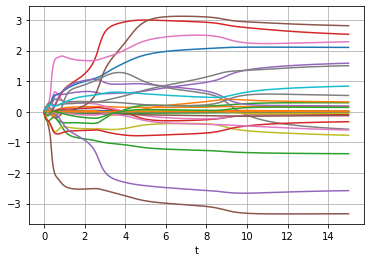

In [111]:
import matplotlib.pyplot as plt
for i in range(coeff*N):
    plt.plot(time_domain, [row[i] for row in Y])
#plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
#plt.xlim(5.9,6.1)
plt.show()

In [112]:
for i in range(coeff*N):  
    print(Y[-1][i])

0.022624343499398212
0.16054936219045193
0.2942652408977212
-0.09776140344315928
1.5866193466963128
-3.3354486766576192
-0.13051253867189438
1.5059432684616125
1.4291874372043662e-13
-8.034018329880533e-14
2.102682952502039
0.026725609073836126
-1.3717503374319753
2.531771311712737
0.1884469074170837
2.811232932884522
2.2874042063392865
-0.5709469078702206
-0.7698927741509278
-2.687828739723441e-13
4.219348512846002e-13
0.3222240653265588
-0.007576421965277909
-0.32578281095971395
-2.5787426724588185
-0.12147895708087751
-0.5971930142432156
0.5309862156767488
-0.047234251342854375
0.8382866206250887
7.80929774635146e-05
0.0011009841875811313
0.14162312532318524


In [113]:
obs = [[1.,2]]
obs_1 = [[-1.,1]]


obs_map = [
            ["z", obs], 
            ["z", obs_1], 


]

observable = hamiltonian(obs_map,dynamic_list=[],basis=basis,**no_checks)
observable_matrix = observable.toarray()
observable_matrix_p = observable_matrix
for i in range(L+1):
    observable_matrix_p = (Proj[i]+Proj_0[i])@observable_matrix_p@(Proj[i]+Proj_0[i])
    
observable_matrix = observable_matrix_p



In [114]:
def var_ansatz(theta,psi_0):
    psi = psi_0
    for i in range(coeff*N):
        psi = R(coeff*N-1-i,theta[coeff*N-1-i])@psi

    return psi

In [115]:
def hamiltonian_evolution(theta):
    return expm(-1j*full_ham_matrix.toarray()*theta)

def hamiltonian_evolution_1(theta):
    return expm(-1j*constrained_full_ham_matrix.toarray()*theta)

In [116]:
psi = var_ansatz(start_point,psi_0)

In [117]:
psi_ground = eigenvec[:,0]


In [118]:
expt_value_u = np.zeros(len(time_domain))
energy = np.zeros(len(time_domain))

psi = var_ansatz(start_point,psi_0)
for tt in range(len(time_domain)):
    theta = []
    for i in range(coeff*N):
        theta.append(Y[tt][i])

    psi_var = var_ansatz(theta,psi_0)
    for i in range(L+1):
        psi_var = (Proj[i]+Proj_0[i])@psi_var
    norm = np.sqrt(np.real(np.conj(psi_var)@psi_var))
    print(norm)

    expt_value_u[tt] = np.abs(np.conj(psi_var)@psi_ground/norm)**2
    energy[tt] = np.real(np.conj(psi_var)@full_ham_matrix@psi_var/norm**2)


0.9999847707708884
0.9999847720546919
0.9999847695815401
0.9999847597903496
0.9999847218610437
0.9999846404498632
0.9999845032477157
0.9999843259356714
0.999984104328738
0.9999838636733578
0.999983631092117
0.9999834122335586
0.999983195362611
0.9999829509080195
0.9999826678558599
0.99998234295922
0.9999819704655573
0.9999815481604087
0.9999810634068398
0.9999805084771486
0.9999798767158321
0.9999791607627014
0.9999783527911574
0.9999777574858612
0.9999768509660706
0.9999761002447862
0.9999749108719134
0.9999739557545997
0.9999725320251492
0.9999713387030282
0.9999696558239964
0.9999681935719009
0.9999663316002222
0.9999643143818827
0.9999624114947304
0.99996010405245
0.9999578767512494
0.9999552502099188
0.9999526758426999
0.9999498906220192
0.999946902197398
0.9999437046848348
0.9999405908393803
0.9999373044485431
0.9999338480839455
0.9999301902133197
0.9999264457286025
0.9999225395991945
0.9999184455047903
0.9999141247639872
0.9999095301349801
0.9999046115271323
0.999899320743839
0.

0.9930791365334748
0.9930813699964589
0.9930835877469455
0.9930857909038135
0.9930879805653342
0.9930901578085112
0.9930923236885121
0.9930944792382059
0.9930966254677679
0.9930987633643776
0.9931008938919786
0.9931030179911053
0.9931051365787746
0.9931072505484226
0.9931093607699105
0.9931114680895493
0.9931135733301893
0.9931156772913364
0.9931177807492985
0.9931198844573773
0.9931219891460678
0.9931240955232982
0.9931262042746808
0.9931283160637883
0.9931304315324415
0.9931325513010144
0.9931346759687567
0.9931368061141118
0.9931389422950595
0.9931410850494617
0.9931432348954039
0.9931453923315539
0.9931475578375203
0.9931497318742091
0.9931519148841839
0.9931541072920226
0.9931563095046851
0.9931585219118595
0.9931607448863259
0.9931629787843044
0.9931652239458012
0.9931674806949562
0.9931697493403764
0.9931720301754696
0.9931743234787762
0.9931766295142814
0.9931789485317298
0.9931812807669385
0.9931836264420827
0.9931859857659945
0.9931883589344367
0.9931907461303819
0.9931931475

0.9926812937041549
0.9926777634945042
0.9926742405617018
0.9926707248739608
0.9926672163991174
0.9926637151046461
0.9926602209576799
0.9926567339250219
0.9926532539731562
0.9926497810682721
0.9926463151762693
0.9926428562627846
0.9926394042931863
0.9926359592326093
0.9926325210459528
0.9926290896979046
0.9926256651529474
0.9926222473753743
0.9926188363293003
0.9926154319786796
0.9926120342873118
0.9926086432188583
0.9926052587368531
0.9926018808047136
0.9925985093857532
0.992595144443195
0.9925917859401805
0.9925884338397808
0.9925850881050132
0.9925817486988421
0.9925784155841973
0.9925750887239881
0.9925717680811038
0.9925684536184286
0.9925651452988565
0.992561843085301
0.9925585469406961
0.9925552568280153
0.9925519727102787
0.992548694550569
0.992545422312027
0.9925421559578778
0.9925388954514294
0.9925356407560889
0.9925323918353665
0.992529148652892
0.9925259111724181
0.9925226793578342
0.9925194531731719
0.9925162325826189
0.9925130175505265
0.992509808041421
0.9925066040200043

0.9935451496884279
0.9935526080530724
0.993560004978853
0.9935673409837
0.9935746165859528
0.9935818323040634
0.9935889886563366
0.9935960861606711
0.9936031253343124
0.9936101066936313
0.9936170307538982
0.9936238980290889
0.9936307090316812
0.9936374642724787
0.9936441642604419
0.9936508095025157
0.9936574005034923
0.9936639377658565
0.9936704217896587
0.9936768530723872
0.9936832321088503
0.9936895593910676
0.9936958354081714
0.993702060646305
0.9937082355885336
0.9937143607147738
0.9937204365017045
0.9937264634227021
0.9937324419477738
0.9937383725435057
0.9937442556729941
0.9937500917958108
0.9937558813679477
0.9937616248417829
0.9937673226660388
0.9937729752857513
0.993778583142247
0.9937841466731072
0.9937896663121509
0.993795142489422
0.993800575631161
0.9938059661598061
0.9938113144939749
0.9938166210484541
0.9938218862342088
0.9938271104583615
0.9938322941242047
0.9938374376311997
0.9938425413749784
0.99384760574735
0.9938526311363102
0.993857617926047
0.9938625664969535
0.99

0.9945915610542574
0.9945922648686669
0.994592966284996
0.9945936653147722
0.9945943619694502
0.9945950562604012
0.9945957481989242
0.9945964377962371
0.994597125063484
0.9945978100117306
0.9945984926519712
0.9945991729951226
0.9945998510520314
0.9946005268334664
0.994601200350128
0.9946018716126437
0.9946025406315698
0.9946032074173868
0.9946038719805155
0.9946045343312961
0.9946051944800074
0.9946058524368551
0.9946065082119827
0.994607161815459
0.9946078132572921
0.9946084625474207
0.9946091096957189
0.994609754711995
0.9946103976059958
0.9946110383873987
0.9946116770658228
0.9946123136508184
0.9946129481518812
0.9946135805784356
0.9946142109398524
0.9946148392454377
0.9946154655044388
0.9946160897260411
0.994616711919371
0.9946173320934967
0.9946179502574278
0.9946185664201149
0.9946191805904504
0.9946197927772756
0.994620402989365
0.9946210112354444
0.9946216175241829
0.9946222218641915
0.9946228242640274
0.994623424732197
0.9946240232771466
0.9946246199072729
0.9946252146309191
0

(0.95, 0.99)

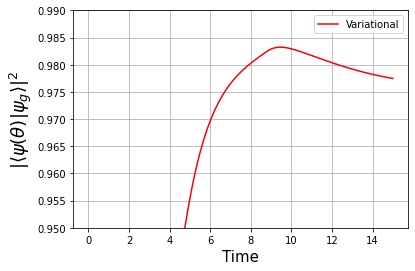

In [124]:
plt.plot(time_domain,expt_value_u, color = "red",label = "Variational")

plt.ylabel(r"$|\langle \psi(\theta)|\psi_g\rangle|^2$",size = 18)
plt.xlabel('Time',size = 15)
plt.grid()
plt.legend()
#plt.xlim(2.8,3)
plt.ylim(0.95,0.99)

#plt.savefig("real_time_evolution\fermion_numbers_1layer.pdf")

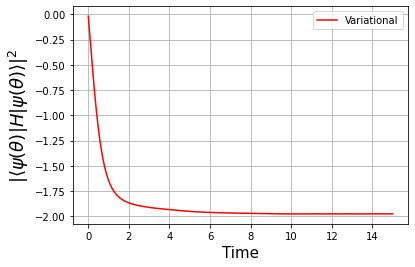

In [123]:
plt.plot(time_domain,energy, color = "red",label = "Variational")

plt.ylabel(r"$|\langle \psi(\theta)|H|\psi(\theta)\rangle|^2$",size = 18)
plt.xlabel('Time',size = 15)
plt.grid()
plt.legend()
#plt.xlim(0,10)
#plt.ylim(-1.35,-1.25)

#plt.savefig("real_time_evolution\fermion_numbers_1layer.pdf")

In [121]:
print(expt_value_u[-1])

0.9774710750641998


In [124]:
a = np.array([1,2,4])
ind = [1,3,5]
for i in ind:
    a = np.insert(a,i,i)
    print(a)

[1 1 2 4]
[1 1 2 3 4]
[1 1 2 3 4 5]


In [33]:
vec = np.array([1,2,3,4,5])
print(vec[-1]-vec[0])

4
